### 0. Install and Import Dependencies

In [5]:
%pip install mediapipe opencv-python

Note: you may need to restart the kernel to use updated packages.


In [6]:
import mediapipe as mp
import cv2

In [7]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

### 1. Make Detections

In [8]:
cap = cv2.VideoCapture(0) # the 0 is the camera index, might need change depending on the setup
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
fps = cap.get(cv2.CAP_PROP_FPS)


with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Ignoring empty camera frame.")
            break
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # converting the frame from BGR to RGB
        image.flags.writeable = False # preventing copying the image data
        results = holistic.process(image) # processing the image

        # Recolor image back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
        
        # Draw right hand landmarks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(80,44,10), thickness=2, circle_radius=4))
        
        # Draw left hand landmarks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(80,44,10), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4))
        
        # Draw pose landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(80,44,10), thickness=2, circle_radius=4))
        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1711557985.801614  517309 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1711557985.893057  562372 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### 2. Data processing

The dataset was taken from this source: https://www.kaggle.com/code/ayushsaini04/face-expression-recognition-with-deep-learning

Here, some of the data are presented. All images have a resolution 48x48. The images appearing in the plot are random images of the train dataset.

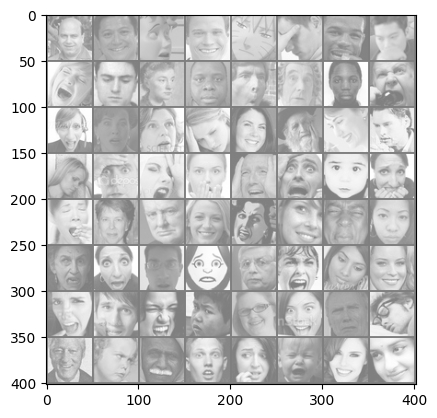

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torchvision import transforms, datasets, utils
from PIL import Image
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
])

# input path for the images
base_path = "data/archive/images/"

# defining train dataset
train_dataset = datasets.ImageFolder(root=os.path.join(base_path, "train"), transform=transform)

# creating a DataLoader for the train dataset
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# function to display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# show images
imshow(utils.make_grid(images))


Let's count the number of images for each facial expression

In [10]:
print("No. of images in the training split: ")
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

print("\nNo. of images in the validation split: ")
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")

No. of images in the training split: 
3205 surprise images
436 disgust images
7164 happy images
4938 sad images
4103 fear images
4982 neutral images
3993 angry images

No. of images in the validation split: 
797 surprise images
111 disgust images
1825 happy images
1139 sad images
1018 fear images
1216 neutral images
960 angry images


The "disgust" images appear to be much lesser than the other categories. This significant imbalance could potentially cause problems to the model.

A good solution to this issue is to augment the images of the "disgust" dataset, so that we create more samples of this class and thus improve the model's accuracy.

Original: 


/tmp/ipykernel_517309/3631912447.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path + random.choice(os.listdir(disgust_path)))


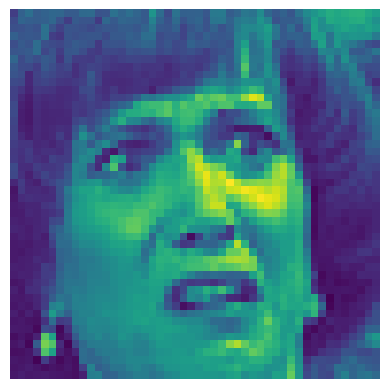

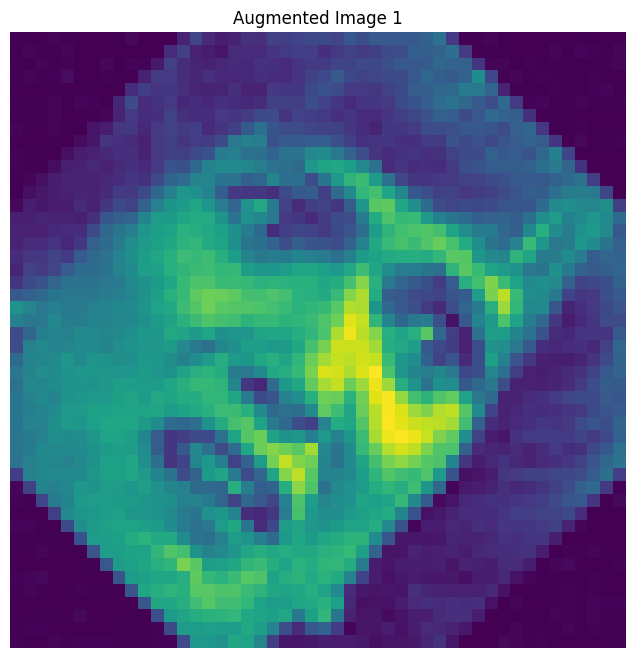

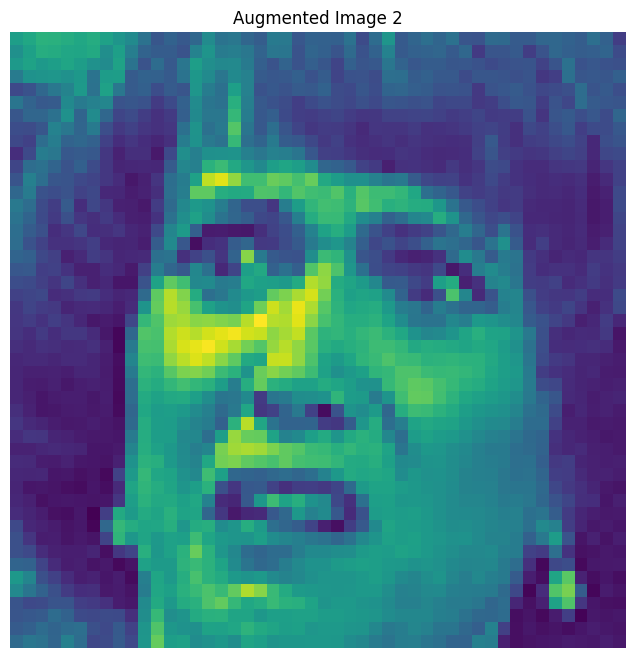

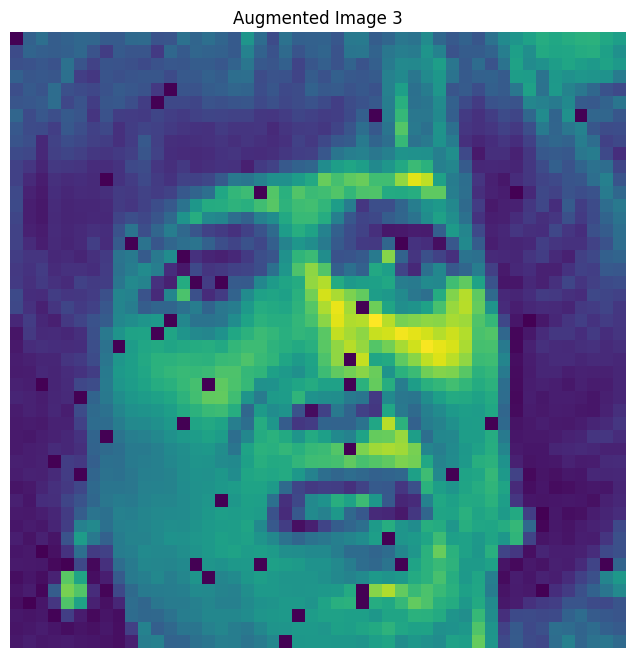

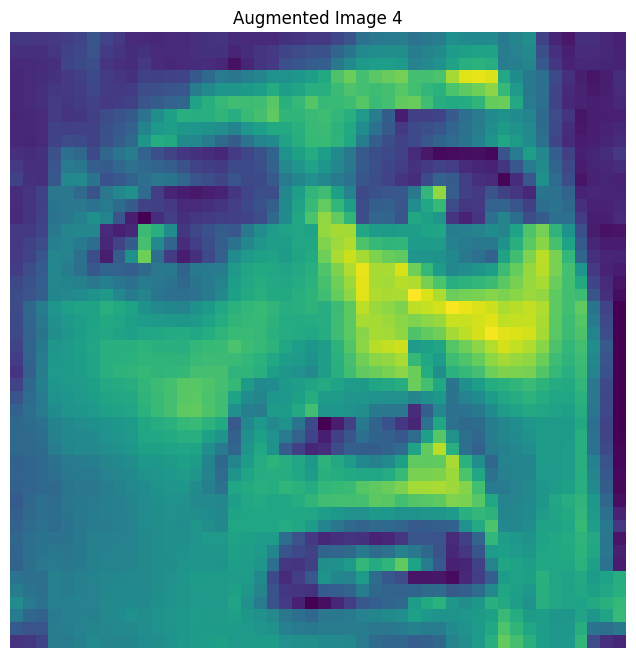

In [30]:
# Load a random image and display it

import imageio
import imgaug as ia
import matplotlib.pyplot as plt
import random

%matplotlib inline

disgust_path = "data/archive/images/train/disgust/"
disgust_path_val = "data/archive/images/validation/disgust/"
image = imageio.imread(disgust_path + random.choice(os.listdir(disgust_path)))

print("Original: ")
plt.imshow(image)
plt.axis('off')
plt.show()


# Augment the Image

from imgaug import augmenters as iaa
ia.seed(4)

# Define different sequential augmenters
seq1 = iaa.Sequential([
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.01*255)
])

seq2 = iaa.Sequential([
    iaa.Fliplr(1)  # Horizontal flip
])

seq3 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0.01, 0.05)),
    iaa.Dropout(p=(0.01, 0.05)),
])

seq4 = iaa.Sequential([
    iaa.Crop(percent=(0, 0.2)),  # random crops
    iaa.Sharpen(alpha=(0.01, 0.05))  # sharpen the image
])

# List of all sequentials
sequentials = [seq1, seq2, seq3, seq4]


for i, seq in enumerate(sequentials, start=1):
    # Apply augmentation
    image_aug = seq(image=image)
    
    # Display the augmented image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_aug)
    plt.axis('off')
    plt.title(f'Augmented Image {i}')
    plt.show()

We are going to do the same thing as in the above cell but for all the images in the "disgust" folder, in order to increase the number of samples we are going to use for our training.

(In case we want to delete some of the images we just created, we can run this script)

In [23]:
import os

disgust_path = "data/archive/images/train/disgust/" # add the path here

# List all files in the directory
files_in_directory = os.listdir(disgust_path) 

# Filter for files that end with '_aug.jpg'
files_to_delete = [file for file in files_in_directory if file.endswith('_aug.jpg')]

# Delete the files
for file in files_to_delete:
    os.remove(os.path.join(disgust_path, file))
    print(f"Deleted {file}")


Deleted 4889_aug.jpg
Deleted 14680_aug.jpg
Deleted 6780_aug.jpg
Deleted 23701_aug.jpg
Deleted 33362_aug.jpg
Deleted 20225_aug.jpg
Deleted 16847_aug.jpg
Deleted 17292_aug.jpg
Deleted 8218_aug.jpg
Deleted 8379_aug.jpg
Deleted 416_aug.jpg
Deleted 15050_aug.jpg
Deleted 5964_aug.jpg
Deleted 12280_aug.jpg
Deleted 473_aug.jpg
Deleted 3516_aug.jpg
Deleted 12838_aug.jpg
Deleted 2389_aug.jpg
Deleted 29630_aug.jpg
Deleted 21816_aug.jpg
Deleted 6488_aug.jpg
Deleted 5197_aug.jpg
Deleted 299_aug.jpg
Deleted 30639_aug.jpg
Deleted 32120_aug.jpg
Deleted 19488_aug.jpg
Deleted 11622_aug.jpg
Deleted 2151_aug.jpg
Deleted 35406_aug.jpg
Deleted 6878_aug.jpg
Deleted 16556_aug.jpg
Deleted 23025_aug.jpg
Deleted 20335_aug.jpg
Deleted 27765_aug.jpg
Deleted 24955_aug.jpg
Deleted 32289_aug.jpg
Deleted 19251_aug.jpg
Deleted 14685_aug.jpg
Deleted 15027_aug.jpg
Deleted 35296_aug.jpg
Deleted 9472_aug.jpg
Deleted 13248_aug.jpg
Deleted 19911_aug.jpg
Deleted 14153_aug.jpg
Deleted 35786_aug.jpg
Deleted 5830_aug.jpg
Deleted

In [31]:
for pic in os.listdir(disgust_path):
    image = imageio.imread(disgust_path + pic)
    for i, seq in enumerate(sequentials, start=1):
        image_aug = seq(image=image)
        imageio.imwrite(os.path.join(disgust_path, pic[:-4] + f"_aug{i}.jpg"), image_aug)
    
for pic in os.listdir(disgust_path_val):
    image = imageio.imread(disgust_path_val + pic)
    for i, seq in enumerate(sequentials, start=1):
        image_aug = seq(image=image)
        imageio.imwrite(os.path.join(disgust_path_val, pic[:-4] + f"_aug{i}.jpg"), image_aug)

/tmp/ipykernel_517309/4002025705.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path + pic)
/tmp/ipykernel_517309/4002025705.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path_val + pic)


In [32]:
print("No. of images in the training split: ")
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

print("\nNo. of images in the validation split: ")
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")

No. of images in the training split: 
3205 surprise images
2180 disgust images
7164 happy images
4938 sad images
4103 fear images
4982 neutral images
3993 angry images

No. of images in the validation split: 
797 surprise images
555 disgust images
1825 happy images
1139 sad images
1018 fear images
1216 neutral images
960 angry images
